In [1]:
from ddpm_conditional import Diffusion
from modules import UNet_conditional
device = "cuda"

In [2]:
import torch

def check_cuda_availability():
    if torch.cuda.is_available():
        print("CUDA is available.")
    else:
        print("CUDA is not available.")

check_cuda_availability()


CUDA is available.


In [3]:
model = UNet_conditional(num_classes=10).to(device)


In [4]:
import torch
ckpt = torch.load("./completed_models/ddpm_con_alld/ckpt.pt")
model.load_state_dict(ckpt)

<All keys matched successfully>

In [5]:
diffusion = Diffusion(img_size=16, device=device)


In [6]:
labels = [0,1,2,3,4,5,6,7,8,9] * 5
label_tensor = torch.tensor(labels).to(device)


In [7]:
import matplotlib.pyplot as plt

def plot_sampled_images(sampled_imgs):
    if sampled_imgs.dim() == 3:  # If there's no batch dimension
        sampled_imgs = sampled_imgs.unsqueeze(0)  # Add batch dimension
    num_images = sampled_imgs.size(0)
    num_cols = 5
    num_rows = num_images // num_cols + 1  # Adjust the number of rows based on the number of images
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
    for i, ax in enumerate(axes.flat):
        if i < num_images:
            if sampled_imgs.size(1) == 1:  # Check if the image is single-channel (grayscale)
                ax.imshow(sampled_imgs[i].squeeze().cpu().numpy(), cmap='gray')
            else:  # If the image has multiple channels (e.g., RGB)
                ax.imshow(sampled_imgs[i].permute(1, 2, 0).cpu().numpy())
            ax.axis('off')
        else:
            ax.axis('off')  # Turn off axes for empty subplots
    plt.tight_layout()
    plt.show()


In [8]:
sigmas = diffusion.beta

In [9]:
print(sigmas)

tensor([0.2000, 0.1993, 0.1987, 0.1980, 0.1973, 0.1966, 0.1960, 0.1953, 0.1947,
        0.1940, 0.1933, 0.1927, 0.1920, 0.1914, 0.1907, 0.1901, 0.1894, 0.1888,
        0.1882, 0.1875, 0.1869, 0.1862, 0.1856, 0.1850, 0.1843, 0.1837, 0.1831,
        0.1825, 0.1818, 0.1812, 0.1806, 0.1800, 0.1794, 0.1787, 0.1781, 0.1775,
        0.1769, 0.1763, 0.1757, 0.1751, 0.1745, 0.1739, 0.1733, 0.1727, 0.1721,
        0.1715, 0.1709, 0.1703, 0.1697, 0.1692, 0.1686, 0.1680, 0.1674, 0.1668,
        0.1663, 0.1657, 0.1651, 0.1645, 0.1640, 0.1634, 0.1628, 0.1623, 0.1617,
        0.1611, 0.1606, 0.1600, 0.1595, 0.1589, 0.1583, 0.1578, 0.1572, 0.1567,
        0.1561, 0.1556, 0.1551, 0.1545, 0.1540, 0.1534, 0.1529, 0.1524, 0.1518,
        0.1513, 0.1508, 0.1502, 0.1497, 0.1492, 0.1487, 0.1481, 0.1476, 0.1471,
        0.1466, 0.1461, 0.1455, 0.1450, 0.1445, 0.1440, 0.1435, 0.1430, 0.1425,
        0.1420, 0.1415, 0.1410, 0.1405, 0.1400, 0.1395, 0.1390, 0.1385, 0.1380,
        0.1375, 0.1370, 0.1365, 0.1360, 

In [10]:
print(sigmas[2].long())

tensor(0, device='cuda:0')


In [11]:
from tqdm import tqdm
def sample(diffusion, model, n, labels, cfg_scale=1):
    model.eval()
    with torch.no_grad():
        x = torch.randn((n, 1, diffusion.img_size, diffusion.img_size)).to(diffusion.device)
        for i in tqdm(reversed(range(1, diffusion.noise_steps)), position=3):
            if i > 200:
                continue
            t = (torch.ones(n) * i).long().to(diffusion.device)

            # print(t)

            predicted_noise = model(x, t, labels)
            if cfg_scale > 0:
                uncond_predicted_noise = model(x, t, None)
                predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
            alpha = diffusion.alpha[t][:, None, None, None]
            alpha_hat = diffusion.alpha_hat[t][:, None, None, None]
            beta = diffusion.beta[t][:, None, None, None]
            if i > 1:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
            x = x.clamp(-1,1)

            if i % 3 == 0:
              print(f"Current at timestep{i}")
              tmp_x = (x.clamp(-1, 1) + 1) / 2
              tmp_x = (tmp_x * 255).type(torch.uint8)
            #   plot_sampled_images(tmp_x)

    model.train()
    x = (x.clamp(-1, 1) + 1) / 2
    x = (x * 255).type(torch.uint8)
    return 


In [12]:
sampled_imgs = sample(diffusion, model, n = len(label_tensor), labels = label_tensor)

Current at timestep198
Current at timestep195
Current at timestep192
Current at timestep189
Current at timestep186
Current at timestep183
Current at timestep180
Current at timestep177
Current at timestep174
Current at timestep171
Current at timestep168
Current at timestep165
Current at timestep162
Current at timestep159
Current at timestep156
Current at timestep153
Current at timestep150
Current at timestep147
Current at timestep144
Current at timestep141
Current at timestep138
Current at timestep135


Current at timestep132
Current at timestep129
Current at timestep126
Current at timestep123
Current at timestep120
Current at timestep117
Current at timestep114
Current at timestep111
Current at timestep108
Current at timestep105


Current at timestep102
Current at timestep99
Current at timestep96
Current at timestep93


Current at timestep90
Current at timestep87
Current at timestep84
Current at timestep81


Current at timestep78
Current at timestep75
Current at timestep72
Current at timestep69


Current at timestep66
Current at timestep63


Current at timestep60
Current at timestep57


Current at timestep54
Current at timestep51


Current at timestep48
Current at timestep45


Current at timestep42
Current at timestep39


Current at timestep36
Current at timestep33


Current at timestep30
Current at timestep27


Current at timestep24
Current at timestep21


Current at timestep18
Current at timestep15


Current at timestep12
Current at timestep9


Current at timestep6
Current at timestep3




999it [00:12, 79.27it/s]


In [13]:
import os
from PIL import Image

def save_images(images, save_dir='sampled_images'):
    os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
    
    for idx, img in enumerate(images):
        img = img.permute(1, 2, 0).squeeze().cpu().numpy()
        img = Image.fromarray(img, mode='L')  # Assuming grayscale images
        img.save(os.path.join(save_dir, f"final_img{idx}.png"))

# Example usage
save_images(sampled_imgs, save_dir='sampled_images')

In [14]:
print(label_tensor)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
        4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7,
        8, 9], device='cuda:0')


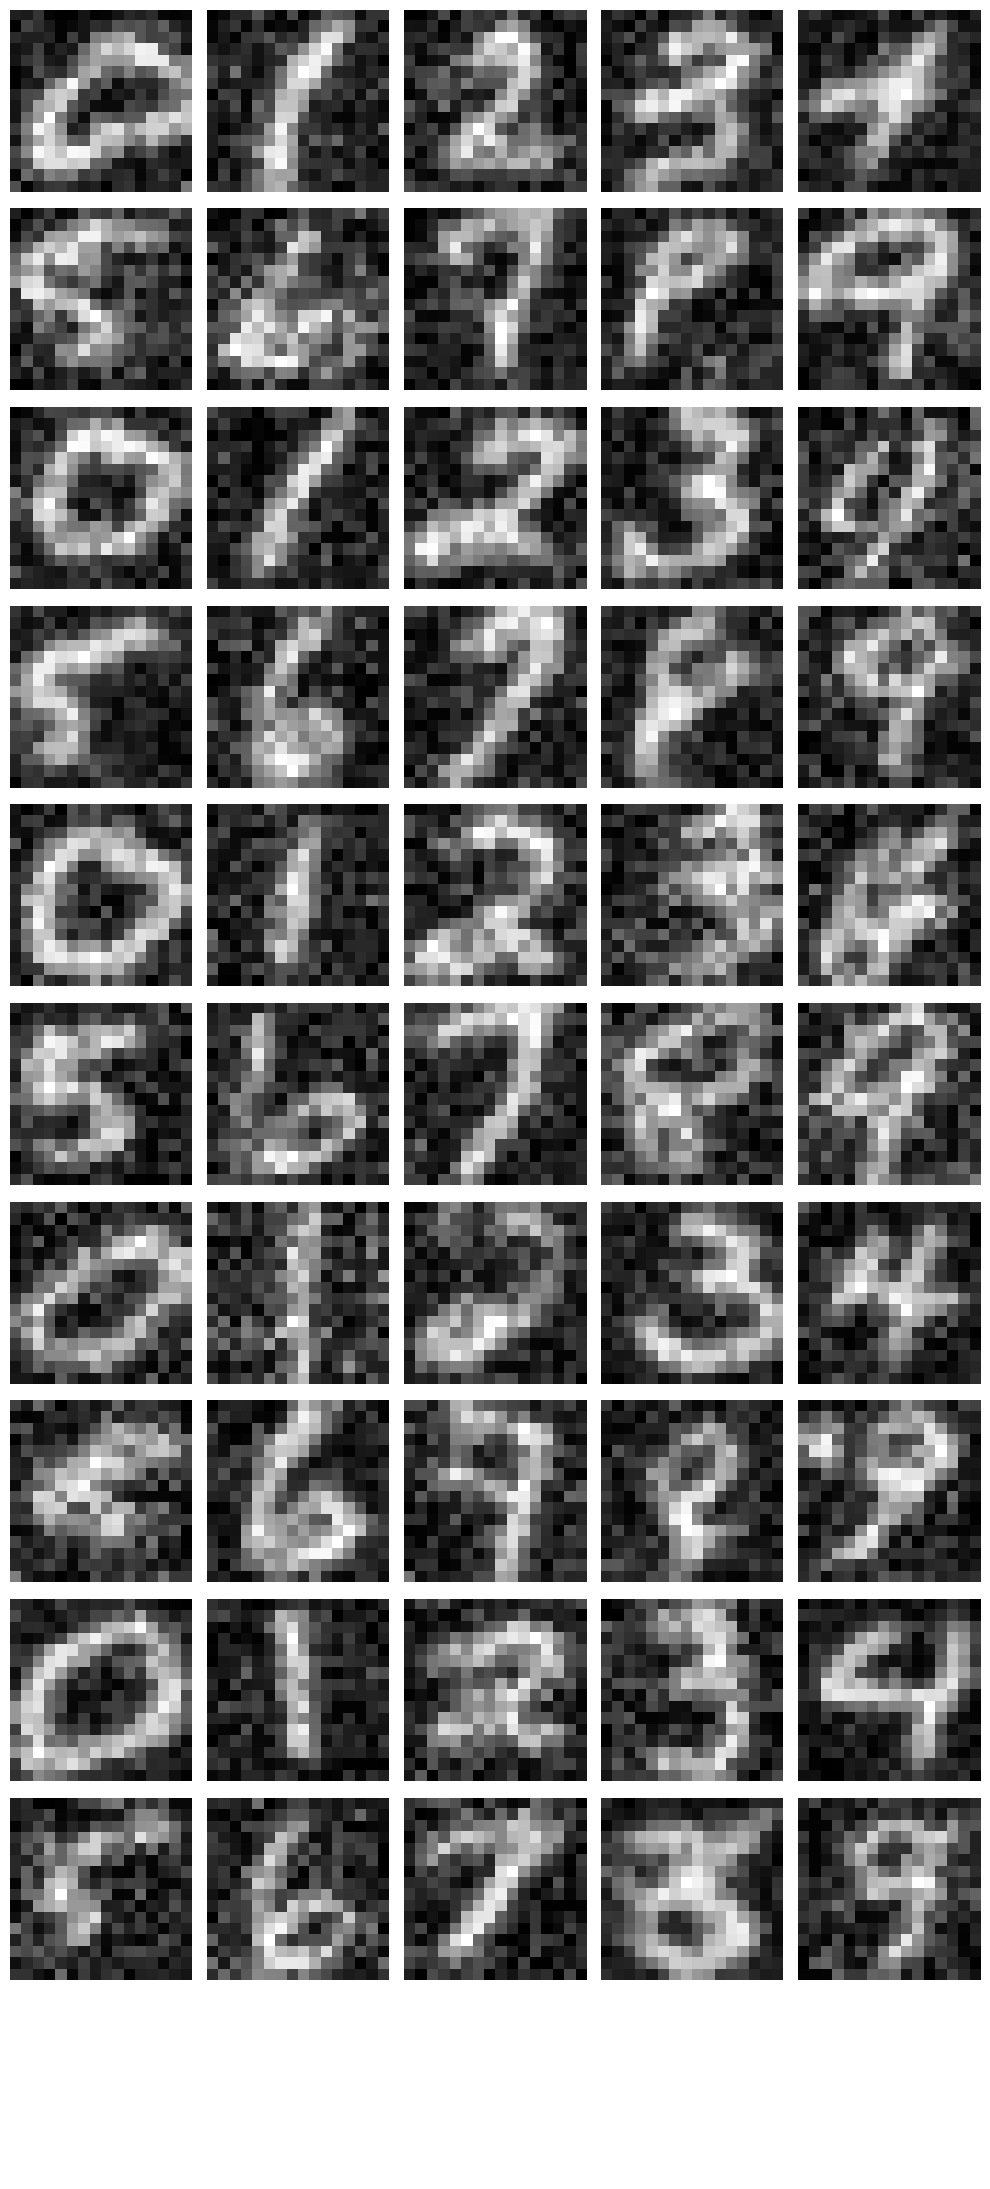

In [15]:
plot_sampled_images(sampled_imgs)